# Controller #

Import all neccessary packages

In [1]:
import os
import pandas as pd
import numpy as np

from controllers.inference_controllers.sandbox import Sandbox
from controllers.inference_controllers.generator import Generator
from controllers.inference_controllers.optimiser import Optimiser

from toolboxes.plotting_toolbox.domain import Domain
from toolboxes.inference_toolbox.parameter import Parameter
from toolboxes.inference_toolbox.model import Model
from toolboxes.inference_toolbox.likelihood import Likelihood

current_directory = os.getcwd()
if current_directory != '/project/':
    os.chdir('/project/')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Defining simulated data

In [2]:
data_params = {
    'data_type': 'normalised_data',
    'data_select': 'GBR_data',
    'normaliser_select': 'GBR_normaliser',
    'normaliser_params':{
        'experiments_list': [
            'Exp1',
            'Exp2',
            'Exp3',
            'Exp4',
            'Exp5',
            'Exp6',
            'Exp7',
            'Exp8',
            'Exp9',
            'Exp10',
            'Exp11',
            'Exp12',
        ],
        'meta_data_select': 'GBR_data_summary',
        'input_header': 'Concentration'
    },
    'log':True,
    'output_header': 'Concentration',
    'gridding': [100,100,25]
}

prior_plots = [
    {
        'I_y': [0.0001, 1.7],
        'references':{
            'I_y' : [0.22, 1.6, 0.11, 0.08, 0.06, 0.04],
            'labels': ['A','B','C','D','E','F'] 
        }
    },
    {
        'I_z': [0.0001, 1.7],
        'references':{
            'I_z' : [0.2, 1.2, 0.08, 0.06, 0.03, 0.016],
            'labels': ['A','B','C','D','E','F'] 
        }
    },
    {
        'Q': [1e12, 5e13],
        'references':{
            'Q' : [2.82e13, 3.11e13, 2.89e13, 4.83e13],
            'labels': ['250m','200m','750m','1000m'] 
        }
    },
    {
        'I_y': [0.0001, 1.7],
        'I_z': [0.0001, 1.7],
        'references':{
            'I_y' : [0.22, 1.6, 0.11, 0.08, 0.06, 0.04],
            'I_z' : [0.2, 1.2, 0.08, 0.06, 0.03, 0.016],
            'labels': ['A','B','C','D','E','F'] 
        }
    }
]

results_name = 'GBR_data_gridded_100_100_25'

Defining default parameters and prior plots for gamma priors of the simulated data

In [3]:
default_params = {
    'infered_params':pd.Series({
        'model_params':pd.Series({
            'I_y': Parameter('I_y', prior_select = 'gamma', default_value=0.1).add_prior_param('mu', 0.1).add_prior_param('sigma',0.1),
            'I_z': Parameter('I_z', prior_select = 'gamma', default_value=0.1).add_prior_param('mu', 0.1).add_prior_param('sigma',0.1),
            'Q': Parameter('Q', prior_select = 'gamma', default_value=3e13).add_prior_param('mu', 3e13).add_prior_param('sigma',1e13),
        }),
        'likelihood_params':pd.Series({
            'sigma': Parameter('sigma', prior_select = 'gamma', default_value=1).add_prior_param('mu', 1).add_prior_param('sigma',1)
        })
    }),
    'model':Model('log_gpm_norm').add_model_param('H',10),
    'likelihood': Likelihood('gaussian'),
    'sampler': {
        'n_samples': 10000,
        'n_chains': 3,
        'thinning_rate': 1
    }
}

Running a general instance for gamma priors and simulated data

In [4]:
sandbox = Sandbox(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

visualiser = sandbox.run()
visualiser.get_summary()
visualiser.get_traceplot()
visualiser.get_autocorrelations()
visualiser.get_prior_plots(prior_plots)

domain = Domain('cone_from_source_z_limited', resolution=80)
domain.add_domain_param('r', 1000)
domain.add_domain_param('theta', np.pi/8)
domain.add_domain_param('source', [0,0,10])

visualiser.visualise_results(domain = domain, name = 'small_scale_3D_plots', title='Log Concentration of Droplets', log_results=False)
visualiser.animate(name = 'small_scale_3D_plots')

Loading Chain Samples...
Loading Samples...
Traceplot 1 already exists
Traceplot 2 already exists
Traceplot 3 already exists
Autocorrelations plot 1 already exists
Autocorrelations plot 2 already exists
Autocorrelations plot 3 already exists
Plots already exist!
Animation already exist!


Analysing the sensitivity of the gamma prior simulated data

In [5]:
generator = Generator(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

analysis_iterations = {
    'parameters_1': ['I_y_mu','I_z_mu','Q_mu','sigma_mu'],
    'parameters_2': ['I_y_sigma','I_z_sigma','Q_sigma','sigma_sigma'],
    'values_1':
    [
        np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]),
        np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]),
        np.array([1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18]),
        np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])     
    ],

    'values_2':
    [
        np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]),
        np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]),
        np.array([1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18]),
        np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) 
    ],
    'scales_1': ['log','log', 'log', 'linear'],
    'scales_2': ['log','log', 'log', 'linear'],
}

for i in range(len(analysis_iterations['parameters_1'])):
    parameter_1 = analysis_iterations['parameters_1'][i]
    parameter_2 = analysis_iterations['parameters_2'][i]

    print('Working on varying ' + parameter_1 + '...')
    values_1 = analysis_iterations['values_1'][i]
    values_2 = analysis_iterations['values_2'][i]

    scale_1 = analysis_iterations['scales_1'][i]
    scale_2 = analysis_iterations['scales_2'][i]

    inputs = generator.vary_two_parameters(parameter_1, parameter_2, values_1, values_2, scale_1=scale_1, scale_2=scale_2, plot=True)

Working on varying I_y_mu...
Working on varying I_z_mu...
Working on varying Q_mu...
Generating instance 1...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5613.62it/s, 15 steps of size 4.69e-01. acc. prob=0.93]


Generating instance 2...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5668.16it/s, 3 steps of size 4.68e-01. acc. prob=0.93]


Generating instance 3...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5824.44it/s, 3 steps of size 5.71e-01. acc. prob=0.89]


Generating instance 4...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5706.89it/s, 3 steps of size 4.88e-01. acc. prob=0.92]


Generating instance 5...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5723.38it/s, 3 steps of size 5.19e-01. acc. prob=0.91]


Generating instance 6...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5747.23it/s, 3 steps of size 4.96e-01. acc. prob=0.92]


Generating instance 7...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5754.41it/s, 3 steps of size 5.14e-01. acc. prob=0.91]


Generating instance 8...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5698.75it/s, 7 steps of size 4.71e-01. acc. prob=0.93]


Generating instance 9...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5639.56it/s, 3 steps of size 4.74e-01. acc. prob=0.93] 


Generating instance 10...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5577.05it/s, 7 steps of size 4.54e-01. acc. prob=0.93]


Generating instance 11...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5681.02it/s, 3 steps of size 5.32e-01. acc. prob=0.90]


Generating instance 12...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5666.00it/s, 15 steps of size 5.37e-01. acc. prob=0.91]


Generating instance 13...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5583.94it/s, 15 steps of size 4.60e-01. acc. prob=0.93]


Generating instance 14...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5634.11it/s, 3 steps of size 4.83e-01. acc. prob=0.92] 


Generating instance 15...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5668.67it/s, 3 steps of size 5.34e-01. acc. prob=0.90]


Generating instance 16...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5654.77it/s, 3 steps of size 4.91e-01. acc. prob=0.92] 


Generating instance 17...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5550.83it/s, 3 steps of size 4.65e-01. acc. prob=0.93]


Generating instance 18...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5544.18it/s, 3 steps of size 4.70e-01. acc. prob=0.93]


Generating instance 19...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5533.60it/s, 15 steps of size 4.53e-01. acc. prob=0.93]


Generating instance 20...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5520.13it/s, 3 steps of size 4.77e-01. acc. prob=0.93] 


Generating instance 21...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5586.40it/s, 3 steps of size 4.64e-01. acc. prob=0.93]


Generating instance 22...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5644.44it/s, 3 steps of size 5.52e-01. acc. prob=0.89]


Generating instance 23...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5289.47it/s, 3 steps of size 4.83e-01. acc. prob=0.93] 


Generating instance 24...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5408.38it/s, 15 steps of size 4.54e-01. acc. prob=0.93]


Generating instance 25...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5387.66it/s, 3 steps of size 4.78e-01. acc. prob=0.93] 


Generating instance 26...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5457.36it/s, 3 steps of size 5.21e-01. acc. prob=0.90]


Generating instance 27...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5471.17it/s, 3 steps of size 4.89e-01. acc. prob=0.92] 


Generating instance 28...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5439.53it/s, 3 steps of size 4.89e-01. acc. prob=0.92]


Generating instance 29...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5510.62it/s, 3 steps of size 5.22e-01. acc. prob=0.91]


Generating instance 30...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5438.41it/s, 3 steps of size 4.80e-01. acc. prob=0.93]


Generating instance 31...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5379.85it/s, 3 steps of size 4.80e-01. acc. prob=0.93]


Generating instance 32...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5489.87it/s, 15 steps of size 5.04e-01. acc. prob=0.92]


Generating instance 33...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5567.31it/s, 3 steps of size 5.62e-01. acc. prob=0.89]


Generating instance 34...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5529.98it/s, 3 steps of size 5.55e-01. acc. prob=0.90] 


Generating instance 35...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5435.61it/s, 7 steps of size 4.70e-01. acc. prob=0.93]


Generating instance 36...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5618.21it/s, 7 steps of size 5.83e-01. acc. prob=0.89]


Generating instance 37...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5446.62it/s, 15 steps of size 4.69e-01. acc. prob=0.93]


Generating instance 38...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5446.61it/s, 3 steps of size 4.51e-01. acc. prob=0.93]


Generating instance 39...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5486.74it/s, 3 steps of size 4.79e-01. acc. prob=0.92]


Generating instance 40...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5508.64it/s, 3 steps of size 4.98e-01. acc. prob=0.92]


Generating instance 41...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5329.45it/s, 23 steps of size 4.47e-01. acc. prob=0.94]


Generating instance 42...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5430.60it/s, 3 steps of size 5.04e-01. acc. prob=0.92]


Generating instance 43...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5288.15it/s, 7 steps of size 4.94e-01. acc. prob=0.92] 


Generating instance 44...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5212.10it/s, 3 steps of size 4.89e-01. acc. prob=0.92] 


Generating instance 45...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5274.88it/s, 3 steps of size 4.87e-01. acc. prob=0.92] 


Generating instance 46...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5104.28it/s, 15 steps of size 4.58e-01. acc. prob=0.93]


Generating instance 47...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5226.28it/s, 3 steps of size 5.28e-01. acc. prob=0.90]


Generating instance 48...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5168.25it/s, 3 steps of size 4.86e-01. acc. prob=0.93]


Generating instance 49...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5187.09it/s, 3 steps of size 5.12e-01. acc. prob=0.91]


Generating instance 50...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5147.80it/s, 3 steps of size 4.85e-01. acc. prob=0.92]


Generating instance 51...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5083.74it/s, 15 steps of size 4.67e-01. acc. prob=0.93]


Generating instance 52...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5210.23it/s, 3 steps of size 5.27e-01. acc. prob=0.91]


Generating instance 53...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5250.31it/s, 7 steps of size 5.35e-01. acc. prob=0.90] 


Generating instance 54...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5160.12it/s, 3 steps of size 5.60e-01. acc. prob=0.89]


Generating instance 55...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5084.62it/s, 15 steps of size 4.65e-01. acc. prob=0.93]


Generating instance 56...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5093.68it/s, 3 steps of size 4.83e-01. acc. prob=0.92] 


Generating instance 57...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5114.01it/s, 3 steps of size 5.15e-01. acc. prob=0.91]


Generating instance 58...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5070.96it/s, 3 steps of size 4.93e-01. acc. prob=0.92]


Generating instance 59...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5095.79it/s, 3 steps of size 4.62e-01. acc. prob=0.93]


Generating instance 60...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5146.15it/s, 3 steps of size 5.20e-01. acc. prob=0.91]


Generating instance 61...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5076.89it/s, 3 steps of size 5.09e-01. acc. prob=0.92]


Generating instance 62...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5044.63it/s, 3 steps of size 4.69e-01. acc. prob=0.93] 


Generating instance 63...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5038.83it/s, 3 steps of size 4.74e-01. acc. prob=0.93]


Generating instance 64...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5061.38it/s, 3 steps of size 4.75e-01. acc. prob=0.93]


Generating instance 65...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5036.72it/s, 3 steps of size 4.81e-01. acc. prob=0.93]


Generating instance 66...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5037.36it/s, 3 steps of size 4.94e-01. acc. prob=0.92]


Generating instance 67...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5057.20it/s, 3 steps of size 4.70e-01. acc. prob=0.93] 


Generating instance 68...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5013.07it/s, 3 steps of size 4.91e-01. acc. prob=0.92]


Generating instance 69...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4975.56it/s, 7 steps of size 4.68e-01. acc. prob=0.93] 


Generating instance 70...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5067.77it/s, 7 steps of size 5.40e-01. acc. prob=0.89]


Generating instance 71...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5002.54it/s, 3 steps of size 4.90e-01. acc. prob=0.92] 


Generating instance 72...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4989.36it/s, 7 steps of size 4.60e-01. acc. prob=0.93]


Generating instance 73...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5078.03it/s, 3 steps of size 5.09e-01. acc. prob=0.92]


Generating instance 74...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5098.31it/s, 3 steps of size 5.05e-01. acc. prob=0.92]


Generating instance 75...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5028.12it/s, 3 steps of size 5.09e-01. acc. prob=0.91]


Generating instance 76...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4906.99it/s, 15 steps of size 4.56e-01. acc. prob=0.93]


Generating instance 77...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5061.56it/s, 3 steps of size 5.07e-01. acc. prob=0.92]


Generating instance 78...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5142.54it/s, 3 steps of size 5.24e-01. acc. prob=0.91]


Generating instance 79...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4989.72it/s, 3 steps of size 4.88e-01. acc. prob=0.92] 


Generating instance 80...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4983.75it/s, 3 steps of size 4.85e-01. acc. prob=0.92]


Generating instance 81...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4991.32it/s, 3 steps of size 4.89e-01. acc. prob=0.92]


Generating instance 82...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5038.46it/s, 3 steps of size 5.48e-01. acc. prob=0.90] 


Generating instance 83...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5074.18it/s, 3 steps of size 5.12e-01. acc. prob=0.91] 


Generating instance 84...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5013.86it/s, 3 steps of size 4.74e-01. acc. prob=0.93]


Generating instance 85...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5032.22it/s, 15 steps of size 4.97e-01. acc. prob=0.91]


Generating instance 86...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5056.87it/s, 3 steps of size 5.15e-01. acc. prob=0.91] 


Generating instance 87...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4925.44it/s, 15 steps of size 4.48e-01. acc. prob=0.94]


Generating instance 88...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4971.95it/s, 3 steps of size 5.06e-01. acc. prob=0.91]


Generating instance 89...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4972.14it/s, 15 steps of size 5.13e-01. acc. prob=0.92]


Generating instance 90...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5040.79it/s, 3 steps of size 4.93e-01. acc. prob=0.92] 


Generating instance 91...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4959.83it/s, 3 steps of size 5.10e-01. acc. prob=0.91]


Generating instance 92...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4946.71it/s, 3 steps of size 4.91e-01. acc. prob=0.92]


Generating instance 93...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4886.65it/s, 15 steps of size 4.63e-01. acc. prob=0.93]


Generating instance 94...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4944.63it/s, 3 steps of size 5.50e-01. acc. prob=0.90]


Generating instance 95...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4926.12it/s, 3 steps of size 4.81e-01. acc. prob=0.92]


Generating instance 96...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4916.42it/s, 3 steps of size 4.69e-01. acc. prob=0.93]


Generating instance 97...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5196.36it/s, 3 steps of size 4.75e-01. acc. prob=0.93] 


Generating instance 98...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5255.24it/s, 3 steps of size 4.86e-01. acc. prob=0.93] 


Generating instance 99...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5310.56it/s, 3 steps of size 5.01e-01. acc. prob=0.92] 


Generating instance 100...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5249.58it/s, 15 steps of size 4.63e-01. acc. prob=0.93]


Working on varying sigma_mu...
Generating instance 1...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5314.91it/s, 7 steps of size 4.83e-01. acc. prob=0.93] 


Generating instance 2...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5314.64it/s, 3 steps of size 4.89e-01. acc. prob=0.92] 


Generating instance 3...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5241.29it/s, 3 steps of size 4.82e-01. acc. prob=0.93]


Generating instance 4...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5260.46it/s, 3 steps of size 4.70e-01. acc. prob=0.93] 


Generating instance 5...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5353.73it/s, 7 steps of size 4.73e-01. acc. prob=0.93]


Generating instance 6...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5231.90it/s, 3 steps of size 4.82e-01. acc. prob=0.93]


Generating instance 7...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5322.97it/s, 3 steps of size 4.51e-01. acc. prob=0.94]


Generating instance 8...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5201.63it/s, 3 steps of size 4.87e-01. acc. prob=0.93] 


Generating instance 9...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5347.29it/s, 3 steps of size 5.06e-01. acc. prob=0.92]


Generating instance 10...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5415.19it/s, 3 steps of size 5.08e-01. acc. prob=0.92] 


Generating instance 11...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5303.35it/s, 3 steps of size 4.94e-01. acc. prob=0.92]


Generating instance 12...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5253.60it/s, 3 steps of size 4.54e-01. acc. prob=0.93]


Generating instance 13...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5255.23it/s, 15 steps of size 4.61e-01. acc. prob=0.93]


Generating instance 14...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5366.43it/s, 3 steps of size 5.36e-01. acc. prob=0.90]


Generating instance 15...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5329.87it/s, 3 steps of size 5.03e-01. acc. prob=0.92]


Generating instance 16...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5424.94it/s, 3 steps of size 5.08e-01. acc. prob=0.92]


Generating instance 17...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5354.89it/s, 7 steps of size 4.63e-01. acc. prob=0.93] 


Generating instance 18...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5455.24it/s, 3 steps of size 4.89e-01. acc. prob=0.92]


Generating instance 19...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5302.17it/s, 3 steps of size 4.64e-01. acc. prob=0.93]


Generating instance 20...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5334.62it/s, 3 steps of size 4.99e-01. acc. prob=0.92] 


Generating instance 21...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5359.73it/s, 7 steps of size 4.85e-01. acc. prob=0.92] 


Generating instance 22...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5435.20it/s, 3 steps of size 5.18e-01. acc. prob=0.91]


Generating instance 23...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5321.66it/s, 3 steps of size 5.02e-01. acc. prob=0.92] 


Generating instance 24...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5268.72it/s, 15 steps of size 4.54e-01. acc. prob=0.93]


Generating instance 25...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5355.73it/s, 3 steps of size 4.97e-01. acc. prob=0.92]


Generating instance 26...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5401.11it/s, 3 steps of size 5.40e-01. acc. prob=0.90] 


Generating instance 27...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5372.83it/s, 3 steps of size 5.02e-01. acc. prob=0.92] 


Generating instance 28...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5487.00it/s, 3 steps of size 5.47e-01. acc. prob=0.90]


Generating instance 29...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5362.35it/s, 3 steps of size 5.00e-01. acc. prob=0.92]


Generating instance 30...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5346.91it/s, 7 steps of size 4.58e-01. acc. prob=0.93]


Generating instance 31...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5391.95it/s, 3 steps of size 4.94e-01. acc. prob=0.92]


Generating instance 32...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5314.75it/s, 7 steps of size 4.64e-01. acc. prob=0.93] 


Generating instance 33...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5334.19it/s, 7 steps of size 4.67e-01. acc. prob=0.93]


Generating instance 34...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5314.88it/s, 3 steps of size 4.61e-01. acc. prob=0.93]


Generating instance 35...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5314.54it/s, 3 steps of size 5.30e-01. acc. prob=0.91]


Generating instance 36...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5227.16it/s, 3 steps of size 5.13e-01. acc. prob=0.91]


Generating instance 37...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5385.83it/s, 3 steps of size 4.96e-01. acc. prob=0.92] 


Generating instance 38...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5297.13it/s, 15 steps of size 4.69e-01. acc. prob=0.93]


Generating instance 39...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5276.20it/s, 7 steps of size 4.77e-01. acc. prob=0.93]


Generating instance 40...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5273.72it/s, 3 steps of size 5.08e-01. acc. prob=0.91]


Generating instance 41...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5197.45it/s, 3 steps of size 5.02e-01. acc. prob=0.92]


Generating instance 42...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5214.04it/s, 3 steps of size 5.24e-01. acc. prob=0.90]


Generating instance 43...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4989.48it/s, 3 steps of size 4.72e-01. acc. prob=0.93]


Generating instance 44...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5107.27it/s, 3 steps of size 4.99e-01. acc. prob=0.92] 


Generating instance 45...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5220.32it/s, 3 steps of size 4.95e-01. acc. prob=0.92] 


Generating instance 46...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5171.62it/s, 3 steps of size 4.91e-01. acc. prob=0.92] 


Generating instance 47...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5130.88it/s, 3 steps of size 5.00e-01. acc. prob=0.91]


Generating instance 48...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5095.67it/s, 15 steps of size 4.49e-01. acc. prob=0.94]


Generating instance 49...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5200.18it/s, 3 steps of size 5.11e-01. acc. prob=0.91]


Generating instance 50...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5059.63it/s, 3 steps of size 4.56e-01. acc. prob=0.93]


Generating instance 51...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5158.62it/s, 7 steps of size 4.86e-01. acc. prob=0.92]


Generating instance 52...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5113.95it/s, 3 steps of size 4.75e-01. acc. prob=0.93]


Generating instance 53...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5234.27it/s, 3 steps of size 4.98e-01. acc. prob=0.92]


Generating instance 54...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5194.68it/s, 3 steps of size 4.92e-01. acc. prob=0.92]


Generating instance 55...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5143.44it/s, 3 steps of size 5.27e-01. acc. prob=0.90] 


Generating instance 56...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5073.08it/s, 15 steps of size 4.50e-01. acc. prob=0.93]


Generating instance 57...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5002.43it/s, 3 steps of size 4.80e-01. acc. prob=0.93]


Generating instance 58...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5170.32it/s, 3 steps of size 5.40e-01. acc. prob=0.90] 


Generating instance 59...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5090.30it/s, 7 steps of size 4.61e-01. acc. prob=0.93]


Generating instance 60...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4969.70it/s, 3 steps of size 5.18e-01. acc. prob=0.91] 


Generating instance 61...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5275.70it/s, 3 steps of size 5.01e-01. acc. prob=0.92]


Generating instance 62...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5271.57it/s, 7 steps of size 5.25e-01. acc. prob=0.91]


Generating instance 63...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5290.90it/s, 3 steps of size 5.13e-01. acc. prob=0.91] 


Generating instance 64...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5185.36it/s, 7 steps of size 4.59e-01. acc. prob=0.93] 


Generating instance 65...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5277.87it/s, 3 steps of size 5.15e-01. acc. prob=0.91] 


Generating instance 66...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5163.18it/s, 7 steps of size 4.74e-01. acc. prob=0.93]


Generating instance 67...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5260.24it/s, 3 steps of size 5.08e-01. acc. prob=0.92]


Generating instance 68...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5254.48it/s, 3 steps of size 5.31e-01. acc. prob=0.90]


Generating instance 69...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5153.32it/s, 15 steps of size 4.58e-01. acc. prob=0.93]


Generating instance 70...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5274.83it/s, 3 steps of size 5.14e-01. acc. prob=0.91] 


Generating instance 71...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5228.78it/s, 15 steps of size 4.69e-01. acc. prob=0.93]


Generating instance 72...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5185.11it/s, 3 steps of size 4.69e-01. acc. prob=0.93]


Generating instance 73...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4660.35it/s, 3 steps of size 4.60e-01. acc. prob=0.93]


Generating instance 74...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5177.05it/s, 3 steps of size 4.73e-01. acc. prob=0.93]


Generating instance 75...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5220.09it/s, 3 steps of size 4.75e-01. acc. prob=0.93] 


Generating instance 76...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5318.16it/s, 3 steps of size 5.19e-01. acc. prob=0.90]


Generating instance 77...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5166.35it/s, 3 steps of size 4.67e-01. acc. prob=0.93] 


Generating instance 78...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5270.12it/s, 3 steps of size 5.15e-01. acc. prob=0.91] 


Generating instance 79...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5139.06it/s, 15 steps of size 4.61e-01. acc. prob=0.93]


Generating instance 80...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5005.05it/s, 7 steps of size 4.65e-01. acc. prob=0.93]


Generating instance 81...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5072.96it/s, 3 steps of size 4.91e-01. acc. prob=0.92] 


Generating instance 82...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5143.60it/s, 15 steps of size 4.84e-01. acc. prob=0.92]


Generating instance 83...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5176.95it/s, 3 steps of size 5.45e-01. acc. prob=0.89]


Generating instance 84...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4972.08it/s, 7 steps of size 4.81e-01. acc. prob=0.93] 


Generating instance 85...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5158.83it/s, 3 steps of size 5.10e-01. acc. prob=0.91]


Generating instance 86...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5194.99it/s, 3 steps of size 5.39e-01. acc. prob=0.91] 


Generating instance 87...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5162.86it/s, 3 steps of size 4.91e-01. acc. prob=0.93] 


Generating instance 88...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5025.45it/s, 3 steps of size 4.53e-01. acc. prob=0.93]


Generating instance 89...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5129.62it/s, 7 steps of size 4.84e-01. acc. prob=0.93]


Generating instance 90...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5121.85it/s, 3 steps of size 4.88e-01. acc. prob=0.92]


Generating instance 91...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5246.00it/s, 3 steps of size 4.71e-01. acc. prob=0.93] 


Generating instance 92...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5154.43it/s, 3 steps of size 5.12e-01. acc. prob=0.91] 


Generating instance 93...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4994.82it/s, 7 steps of size 4.63e-01. acc. prob=0.93]


Generating instance 94...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5384.56it/s, 3 steps of size 4.71e-01. acc. prob=0.93] 


Generating instance 95...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5027.79it/s, 3 steps of size 5.21e-01. acc. prob=0.91]


Generating instance 96...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 4963.37it/s, 15 steps of size 5.01e-01. acc. prob=0.92]


Generating instance 97...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5220.98it/s, 3 steps of size 4.61e-01. acc. prob=0.93]


Generating instance 98...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5285.66it/s, 3 steps of size 5.11e-01. acc. prob=0.91]


Generating instance 99...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5375.73it/s, 15 steps of size 4.81e-01. acc. prob=0.93]


Generating instance 100...


sample: 100%|██████████| 12500/12500 [00:02<00:00, 5220.36it/s, 15 steps of size 4.80e-01. acc. prob=0.92]


Optimising the hyperparameters for gamma prior simulated data

[I 2023-10-11 05:54:14,546] A new study created in RDB with name: AIC_1
sample: 100%|██████████| 12500/12500 [00:02<00:00, 5128.13it/s, 3 steps of size 5.23e-01. acc. prob=0.91] 
[I 2023-10-11 05:54:25,133] Trial 0 finished with value: 237.39369201660156 and parameters: {'I_y_mu': 7.289265054212893, 'I_y_sigma': 7.401877580952578, 'I_z_mu': 6.496340733068833, 'I_z_sigma': 2.9456790903921903, 'Q_mu': 1.0504240162054573e+17, 'Q_sigma': 6.900347928527343e+17, 'sigma_mu': 0.8487872642016416, 'sigma_sigma': 0.4357954730860833}. Best is trial 0 with value: 237.39369201660156.
sample: 100%|██████████| 12500/12500 [00:02<00:00, 4623.77it/s, 3 steps of size 5.12e-01. acc. prob=0.91]
[I 2023-10-11 05:54:36,537] Trial 1 finished with value: 237.4235382080078 and parameters: {'I_y_mu': 6.329994596831245, 'I_y_sigma': 4.7517655072630305, 'I_z_mu': 7.3704760633256, 'I_z_sigma': 3.608437327920101, 'Q_mu': 1.3249558435526822e+17, 'Q_sigma': 7.943522697793374e+16, 'sigma_mu': 1.7288209384995286, 'sigma

sample: 100%|██████████| 12500/12500 [00:02<00:00, 5007.96it/s, 3 steps of size 4.98e-01. acc. prob=0.92]
[I 2023-10-11 05:55:09,113] Trial 4 finished with value: 237.42230224609375 and parameters: {'I_y_mu': 8.317231893890511, 'I_y_sigma': 3.194085709851302, 'I_z_mu': 5.537901561123522, 'I_z_sigma': 6.3316380597007385, 'Q_mu': 2.4305025017290752e+17, 'Q_sigma': 6.916688249896206e+17, 'sigma_mu': 1.0418290190377075, 'sigma_sigma': 0.8377704359609577}. Best is trial 2 with value: 237.1741943359375.
sample: 100%|██████████| 12500/12500 [00:02<00:00, 5050.42it/s, 7 steps of size 5.76e-01. acc. prob=0.88]
[I 2023-10-11 05:55:19,844] Trial 5 finished with value: 237.4148712158203 and parameters: {'I_y_mu': 1.7372401323469215, 'I_y_sigma': 2.5181846534243153, 'I_z_mu': 8.884765451965064, 'I_z_sigma': 4.456674710807064, 'Q_mu': 6.359503726854744e+17, 'Q_sigma': 8.308030738714089e+17, 'sigma_mu': 1.3666431579666856, 'sigma_sigma': 1.7494948903946141}. Best is trial 2 with value: 237.1741943359

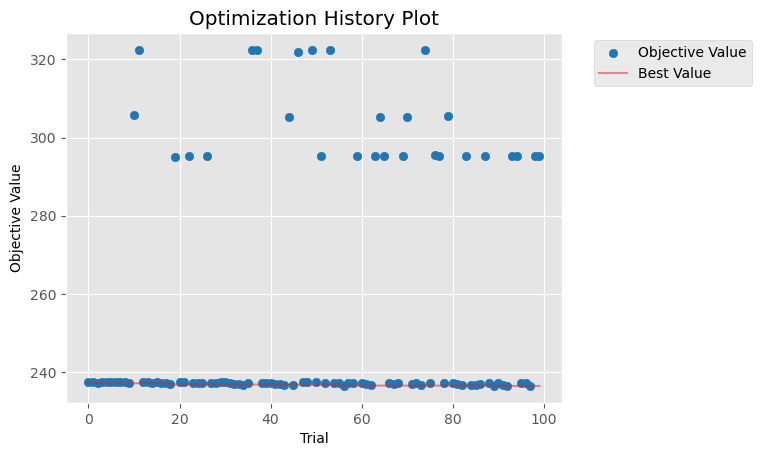

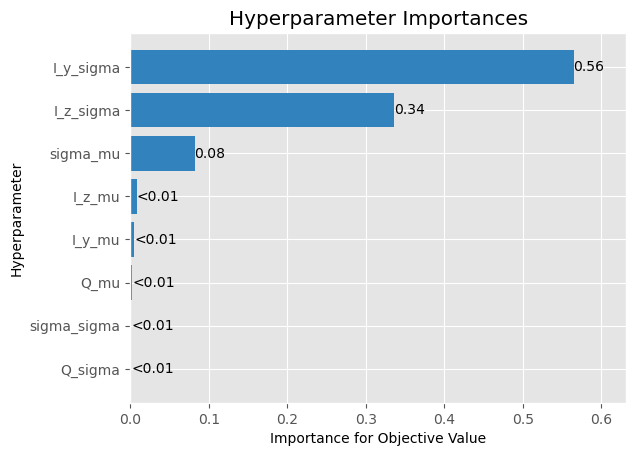

In [6]:
optimising_parameters = {
                    'I_y_mu': [1e-2, 10],
                    'I_y_sigma': [1e-2, 10],
                    'I_z_mu': [1e-2, 10],
                    'I_z_sigma': [1e-2, 10],
                    'Q_mu': [1e9, 1e18],
                    'Q_sigma': [1e9, 1e18],
                    'sigma_mu':[0.2, 2],
                    'sigma_sigma':[0.2, 2]
                }

optimiser = Optimiser(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

# AIC
study = optimiser.run(n_trials=100, optimiser_name='AIC_1', optimising_parameters=optimising_parameters, index_name='aic')
optimiser.get_plots(study)
domain = Domain('cone_from_source_z_limited', resolution=80)
domain.add_domain_param('r', 1000)
domain.add_domain_param('theta', np.pi/8)
domain.add_domain_param('source', [0,0,10])
optimiser.run_best_params(study, domain, name = 'small_scale_3D_plots', prior_plots=prior_plots)

# # RMSE
# study = optimiser.run(n_trials=100, optimiser_name='RMSE_1', optimising_parameters=optimising_parameters, index_name='rmse')
# optimiser.get_plots(study)
# domain = Domain('cone_from_source_z_limited', resolution=80)
# domain.add_domain_param('r', 1000)
# domain.add_domain_param('theta', np.pi/8)
# domain.add_domain_param('source', [0,0,10])
# optimiser.run_best_params(study, domain, name = 'small_scale_3D_plots', prior_plots=prior_plots)

# # BIC
# study = optimiser.run(n_trials=100, optimiser_name='BIC_1', optimising_parameters=optimising_parameters, index_name='bic')
# optimiser.get_plots(study)
# domain = Domain('cone_from_source_z_limited', resolution=80)
# domain.add_domain_param('r', 1000)
# domain.add_domain_param('theta', np.pi/8)
# domain.add_domain_param('source', [0,0,10])
# optimiser.run_best_params(study, domain, name = 'small_scale_3D_plots', prior_plots=prior_plots)